# Decouple Model Execution from Definition

Hongzheng Chen, Cody Hao Yu, Shuai Zheng


## Background and Motivation
* **Performance**: Large gap between native implementations and optimized models. From Mu's slide
    | Model\Performance (TFLOPs) | HuggingFace | Megatron-LM |
    | :--: | :--: | :--: |
    | BERT | 31 | **43** |
    | GPT2 | 19 | **42** |
* **Productivity**
    * Megatron-LM, DeepSpeed ZeRO-3: Parameter sharding; MiCS: prefetching, buffer pre-allocation
    * Manually modify the model
    * Components are not reusable for models other than Transformers
* **Customizability**
    * Alpa automatically searches for the optimial 3D parallelism
    * Compilation passes are monolithic: Cannot just do some optimizations for specific layers and see results (e.g. shard an op)
    * Optimization are opaque: Hard to locate the issues in the compiler


## Proposal: A Model Scheduling DSL
Decouple model execution from definition
* TVM/Halide: Only consider op-level optimization and only for single machine inference workload

Cover optimizations: (which requires manually changing the models in existing works)
1. Parameter sharding
2. Kernel fusion/injection
3. Gradient checkpointing
4. Memory defragmentation
5. ...

## Demos

### (1) Kernel Injection

Import required packages

In [1]:
import os, sys, copy, time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ms # model-scheduling
print(torch.cuda.is_available())

True


Create a simple MLP model with layer norm

In [2]:
N = 2048

class MLP(nn.Module):

    def __init__(self, dim: int):
        super().__init__()
        self.dense_1 = nn.Linear(dim, dim * 2)
        self.layer_norm = nn.LayerNorm([dim, dim * 2])
        self.activation = nn.ReLU()
        self.dense_2 = nn.Linear(dim * 2, dim)

    def forward(self, x):
        x = self.dense_1(x)
        x = self.layer_norm(x)
        x = self.activation(x)
        x = self.dense_2(x)
        return x

Instanciate the model and create an optimizer for traing

In [3]:
device = "cuda:0"
model = MLP(N).to(device)

Create a default schedule

In [4]:
sch = ms.create_schedule(copy.deepcopy(model))

Currently we use torch.fx to trace the model and generate IR for optimization. We can print out the graph module to see the operators.

In [5]:
print(sch.gm.graph)

graph():
    %x : [#users=1] = placeholder[target=x]
    %dense_1 : [#users=1] = call_module[target=dense_1](args = (%x,), kwargs = {})
    %layer_norm : [#users=1] = call_module[target=layer_norm](args = (%dense_1,), kwargs = {})
    %activation : [#users=1] = call_module[target=activation](args = (%layer_norm,), kwargs = {})
    %dense_2 : [#users=1] = call_module[target=dense_2](args = (%activation,), kwargs = {})
    return dense_2


In [ ]:
sch.modules

Print operators in the module

In [6]:
ops = sch.forward_ops
print(ops)

['dense_1', 'layer_norm', 'activation', 'dense_2']


Replace layer_norm with Apex layer_norm. Just a single line!

In [7]:
from apex.normalization.fused_layer_norm import FusedLayerNorm

sch[ops[1]].replace(FusedLayerNorm, [N, N * 2])

Apply the schedule and regenerate the module

In [8]:
opt_model, optimizer = ms.build(sch)
print(opt_model.graph)

GraphModule(
  (dense_1): Linear(in_features=2048, out_features=4096, bias=True)
  (layer_norm): LayerNorm((2048, 4096), eps=1e-05, elementwise_affine=True)
  (activation): ReLU()
  (dense_2): Linear(in_features=4096, out_features=2048, bias=True)
  (FusedLayerNorm): FusedLayerNorm(torch.Size([2048, 4096]), eps=1e-05, elementwise_affine=True)
)



def forward(self, x):
    dense_1 = self.dense_1(x);  x = None
    fused_layer_norm = self.FusedLayerNorm(dense_1);  dense_1 = None
    activation = self.activation(fused_layer_norm);  fused_layer_norm = None
    dense_2 = self.dense_2(activation);  activation = None
    return dense_2
    
# To see more debug info, please use `graph_module.print_readable()`
ShardingPlan(plan={}, output_plan={}, return_local_tensor=['dense_2'])
graph():
    %x : [#users=1] = placeholder[target=x]
    %dense_1 : [#users=1] = call_module[target=dense_1](args = (%x,), kwargs = {})
    %fused_layer_norm : [#users=1] = call_module[target=FusedLayerNorm](args = (%d

In [9]:
inp = torch.rand(N, N).to(device)
original_output = model(inp)
optimized_output = opt_model(inp)
assert torch.allclose(original_output, optimized_output)
print("Results are correct!")

Results are correct!


Pytorch: 0.2251ms
Apex: 0.2225ms


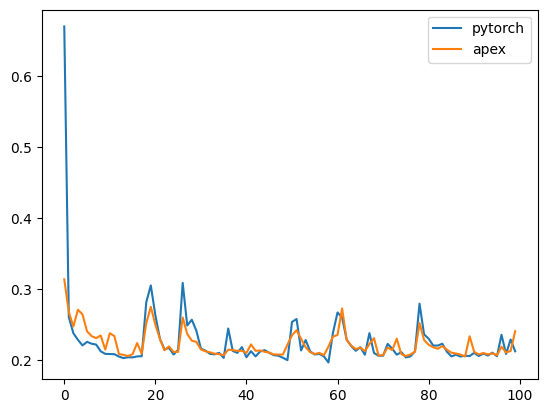

In [10]:
pt_time = []
apex_time = []
for i in range(100):
    inp = torch.rand(N, N).to(device)
    # Test native PyTorch implementation
    start_time = time.time()
    original_output = model(inp)
    pt_time.append((time.time() - start_time) * 1000)
    # Test Apex function
    start_time = time.time()
    optimized_output = opt_model(inp)
    apex_time.append((time.time() - start_time) * 1000)

# plot results
plt.plot(np.arange(100), pt_time, label="pytorch")
plt.plot(np.arange(100), apex_time, label="apex")
plt.legend()
print("Pytorch: {:.4f}ms".format(np.mean(pt_time)))
print("Apex: {:.4f}ms".format(np.mean(apex_time)))

### (1.1) Kernel Fusion

Similarly, we can replace a series of ops with a single fused op/block.

In [11]:
class FusedBlock(nn.Module):

    def __init__(self, dim: int):
        super().__init__()
        self.fc = nn.Linear(dim, dim * 2)
        self.ln = nn.LayerNorm([dim, dim * 2])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.ln(self.fc(x)))
        return x

sch = ms.create_schedule(copy.deepcopy(model))
ops = sch.forward_ops
sch[ops[0:3]].replace(FusedBlock, N)
print(sch.gm.graph)

graph():
    %x : [#users=1] = placeholder[target=x]
    %fused_block : [#users=1] = call_module[target=FusedBlock](args = (%x,), kwargs = {})
    %dense_2 : [#users=1] = call_module[target=dense_2](args = (%fused_block,), kwargs = {})
    return dense_2


### (2) Parameter Sharding



In [12]:
class MLP(nn.Module):

    def __init__(self, dim: int = 32):
        super().__init__()
        intermediate_dim = dim * 2
        self.dense_1 = nn.Linear(dim, intermediate_dim)
        self.activation = nn.ReLU()
        self.dense_2 = nn.Linear(intermediate_dim, dim)

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        return x

def train(rank, world_size):
    print(f"Running basic MLP example on rank {rank}.")

    # === Model execution schedule ===
    model = MLP(32).cuda(rank)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

    # Create a default schedule
    sch = ms.create_schedule(model, optimizer, world_size, rank)
    
    # Access operators
    ops = sch.forward_ops

    # Partition parameters
    # column sharding for dense_1
    sch[ops[0]].partition(axis=1, param="weight")
    # row sharding for dense_2
    sch[ops[2]].partition(axis=0, param="weight")

    # Partition outputs
    # The result from dense_2 needs aggregation
    sch[ops[2]].partition(axis=1)

    # Apply schedule and regenerate module
    model, optimizer = ms.build(sch)

    # Perform a num of iterations of forward/backward
    # and optimizations for the sharded module.
    for i in range(5):
        start_time = time.time()
        inp = torch.rand(16, 32).cuda(rank)
        output = model(inp)
        output.sum().backward()
        optimizer.step()
        elapsed_time = time.time() - start_time
        print(f"Finish step {i}, time: {elapsed_time:.10f}s")

In [13]:
! python3 mlp_ms.py --world_size 2

Running basic MLP example on rank 0.
['dense_1', 'layer_norm', 'activation', 'dense_2']
GraphModule(
  (dense_1): Linear(in_features=32, out_features=64, bias=True)
  (layer_norm): LayerNorm((32, 64), eps=1e-05, elementwise_affine=True)
  (activation): ReLU()
  (dense_2): Linear(in_features=64, out_features=32, bias=True)
)



def forward(self, x):
    dense_1 = self.dense_1(x);  x = None
    layer_norm = self.layer_norm(dense_1);  dense_1 = None
    activation = self.activation(layer_norm);  layer_norm = None
    dense_2 = self.dense_2(activation);  activation = None
    return dense_2
    
# To see more debug info, please use `graph_module.print_readable()`
[W socket.cpp:426] [c10d] The server socket has failed to bind to [::]:12888 (errno: 98 - Address already in use).
[W socket.cpp:426] [c10d] The server socket has failed to bind to 0.0.0.0:12888 (errno: 98 - Address already in use).
[E socket.cpp:462] [c10d] The server socket has failed to listen on any local network address.
Trac